In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import random
import healpy as hp

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

In [6]:
cd

/home/jovyan


## Load files and create columns

#### no-table: LLC no noise

In [7]:
os.getenv('ENDPOINT_URL') 
tbl_file1 = 's3://llc/Tables/test_modis2012.parquet'
no_table = ulmo_io.load_main_table(tbl_file1)

Read main table: s3://llc/Tables/test_modis2012.parquet


In [8]:
no_table['DT'] = no_table.Tmax - no_table.Tmin
no_table['DT_p'] = no_table.T90 - no_table.T10

#### yes-table: LLC with noise

In [13]:
tbl_file2 = 's3://llc/Tables/ulmo2_test.parquet'
yes_table = ulmo_io.load_main_table(tbl_file2)

Read main table: s3://llc/Tables/ulmo2_test.parquet


In [ ]:
with h5py.File('LLC_modis2012_SST_noise_demean_preproc.h5', 'r') as f:
    DT = np.empty( (635295,))
    DT_p = np.empty( (635295,))
    
    for idx in range(635295):
        img = f['valid'][idx, 0, ...]
        DT[idx] = np.max(img) - np.min(img)
        DT_p[idx] = np.percentile(img, 90) - np.percentile(img, 10)

In [11]:
tbl = yes_table.sort_values('pp_idx')
DT_object = pd.Series(data = DT, index = tbl.index)
DT_pobject = pd.Series(data = DT_p, index = tbl.index)

In [12]:
yes_table['DT'] = DT_object
yes_table['DT_p'] = DT_pobject

#### mod-table: MODIS data

In [13]:
tbl_file3 = 's3://modis-l2/Tables/MODIS_L2_std.parquet'
table = ulmo_io.load_main_table(tbl_file3)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [14]:
table['DT'] = table.Tmax - table.Tmin
table['DT_p'] = table.T90 - table.T10

In [15]:
mod_table = table[(table.datetime >= pd.to_datetime('2012-01-01 00:00:00')) & (table.datetime < pd.to_datetime('2012-11-15 11:35:00'))]

# West of Chile

In [16]:
lon1 = (no_table.lon > -125.) & (no_table.lon < -90.)
lat1 = (no_table.lat > -55) & (no_table.lat < -45)

#zone 1
chile_no = no_table[lon1 & lat1]

In [17]:
lon1 = (yes_table.lon > -125.) & (yes_table.lon < -90.)
lat1 = (yes_table.lat > -55) & (yes_table.lat < -45)

#zone 1
chile_yes = yes_table[lon1 & lat1]

In [18]:
lon1 = (mod_table.lon > -125.) & (mod_table.lon < -90.)
lat1 = (mod_table.lat > -55) & (mod_table.lat < -45)

#zone 1
chile_mod = mod_table[lon1 & lat1]

### Geographics

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


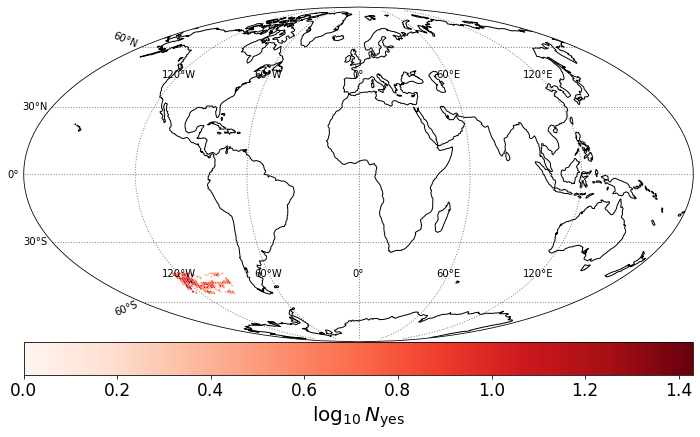

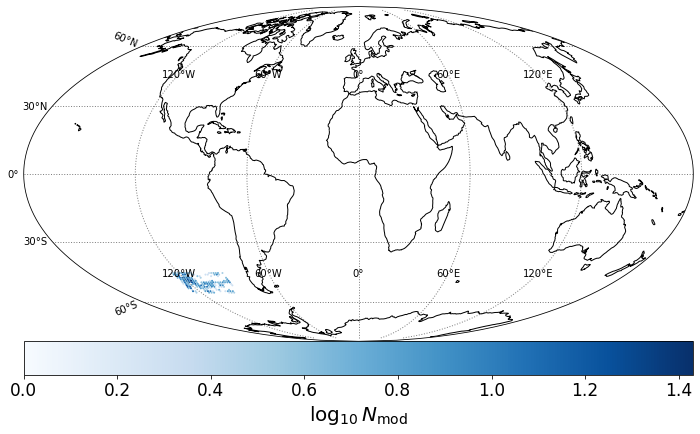

In [20]:
_ = ulmo_figs.show_spatial(chile_yes, lbl = 'yes')
_ = ulmo_figs.show_spatial(chile_mod, lbl = 'mod', color = 'Blues')

### LL Histogram

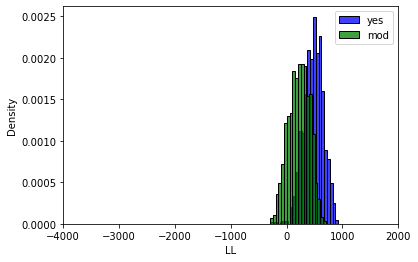

In [31]:
# Give histplot the dataframe and the column name
#ax1 = sns.histplot(data=no_table, x='LL', color = 'y', stat = 'density', label = 'no')
ax1 = sns.histplot(data=chile_yes, x='LL', color = 'b', stat = 'density', binwidth=50, label = 'yes')
ax1 = sns.histplot(data=chile_mod, x='LL', color = 'g', stat = 'density', binwidth=50,label = 'mod')

ax1.set_xlim(-4000., 2000.)
#ax1.set_ylim(0., 0.01)
ax1.legend()

### Mean T Histogram

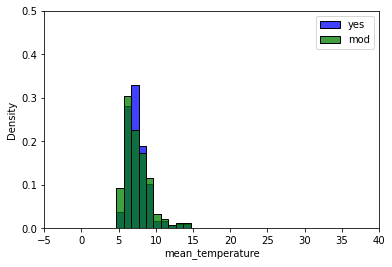

In [38]:
ax1_t = sns.histplot(data= chile_yes, x='mean_temperature', color = 'b', stat = 'density', binwidth=1, label = 'yes')
ax1_t = sns.histplot(data= chile_mod, x='mean_temperature', color = 'g', stat = 'density', binwidth=1, label = 'mod')

ax1_t.set_xlim(-5., 40.)
ax1_t.set_ylim(0., 0.5)
ax1_t.legend()

### DT Histogram

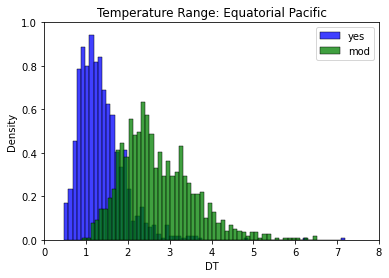

In [39]:
ax1_dt = sns.histplot(data= chile_yes, x='DT', color = 'b', stat = 'density', binwidth=0.1, label = 'yes')
ax1_dt = sns.histplot(data= chile_mod, x='DT', color = 'g', stat = 'density', binwidth=0.1, label = 'mod')

ax1_dt.set_xlim(0., 8.)
ax1_dt.set_ylim(0., 1)
ax1_dt.set_title('Temperature Range: Equatorial Pacific')
ax1_dt.legend()

In [ ]:
### 

In [40]:
#low LL
y90 = np.percentile(chile_yes.LL.to_numpy(), 90)
y10 = np.percentile(chile_yes.LL.to_numpy(), 10)

m90 = np.percentile(chile_mod.LL.to_numpy(), 90)
m10 = np.percentile(chile_mod.LL.to_numpy(), 10)

ylow = chile_yes[chile_yes.LL < y10]

mlow = chile_mod[chile_mod.LL < m10]

#high LL
yhigh = chile_yes[chile_yes.LL > y90]

mhigh = chile_mod[chile_mod.LL > m90]

In [54]:
li = np.random.randint(0, ylow.shape[0], 3)
li

array([17, 88, 80])

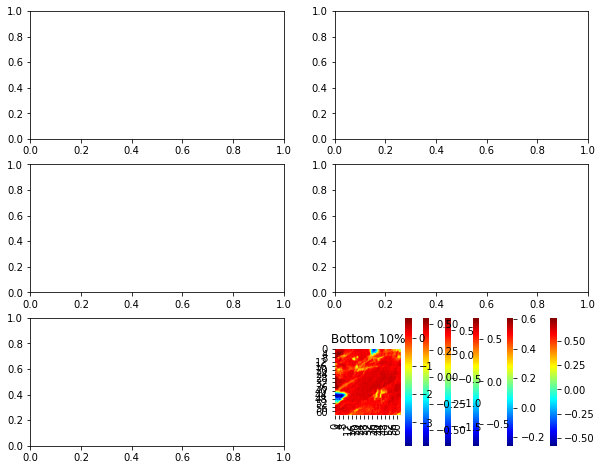

In [55]:
_, cm = ulmo_plotting.load_palette()

fig, axes = plt.subplots(3, 2, figsize = (12, 8))

for row in range(3):
    for col in range (2):
        
        ax = axes[row, col]
        
        if col ==0: 
            cutout = chile_yes.iloc[li[row]]

            img = image_utils.grab_image(cutout)   
            
        else: 
            cutout = chile_mod.iloc[li[row]]

            img = image_utils.grab_image(cutout) 
        ax = sns.heatmap(np.flipud(img), xticklabels=4, yticklabels=4, cmap=cm, cbar=True, square = True, ax = ax)
plt.title('Bottom 10%')
plt.show()

# Patagonian Shelf